# Anomaly Detection of Air Conditioners in Train Control Rooms with Autoencoder/LSTM

Data Discovery Group with BART, University of California, Berkely

Yu Shen

01-2023


## Introduction
This notebook presents an anomaly detection approach for air conditioners in train control rooms.
The data is from the temperature sensors at BART's train control rooms.
The temperature time series labeled as "normal" and "anormal" are used to train an LSTM autoencoder.
The labeling is done by the students of UC. Berkeley.

An LSTM autoencoder is trained to reconstruct the time series the temperature readings of abnormal air conditioners.
We hope that the autoencorder can "memorize" the shape of the abnormal time series, thus we
may use the distance value between the reconstructed time series and the original time series as a metric to detect anomalies.

The method is inspired by the paper ?[Anomaly Detection for Time Series using LSTM Autoencoder](https://arxiv.org/abs/1902.09849).


## import

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from pylab import rcParams

from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
import torch.nn.functional as F

import copy # for copy.deepcopy

## Configuration and Setup

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 2022
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

Read train and test data to dataframe to prepare the data

In [4]:
df = pd.read_csv('../../data/tempseries_labeled.zip') # already labeled time series data in the fixed time window width
# temp0,temp1,temp2,temp3,temp4,temp5,temp6,temp7,temp8,temp9,temp10,temp11,temp12,temp13,temp14,temp15,otemp0,otemp1,otemp2,otemp3,otemp4,otemp5,otemp6,otemp7,otemp8,otemp9,otemp10,otemp11,otemp12,otemp13,otemp14,otemp15,loc,start,end,ab_label
# 71.3,73.5,73.8,70.6,72.2,74.6,72.0,70.7,73.3,73.4,70.7,71.7,74.5,71.9,70.5,73.0,63.0,64.9,64.9,71.1,71.1,64.9,66.9,66.9,66.9,66.9,68.0,68.0,68.0,75.9,69.1,69.1,S12,2022-07-29 10:45:00-07:00,2022-07-29 14:45:00-07:00,0
# 76.3,77.8,77.4,76.5,76.6,77.6,77.1,76.2,73.5,74.9,76.7,77.5,77.8,77.4,77.6,76.1,69.1,66.9,66.9,66.9,66.9,66.9,66.9,66.9,66.9,66.0,66.45,66.0,66.0,64.0,64.0,64.0,W40,2022-06-08 14:45:00-07:00,2022-06-08 18:45:00-07:00,0

In [5]:
df.head()

,temp0,temp1,temp2,temp3,temp4,temp5,temp6,temp7,temp8,temp9,...,otemp10,otemp11,otemp12,otemp13,otemp14,otemp15,loc,start,end,ab_label
0,71.3,73.5,73.8,70.6,72.2,74.6,72.0,70.7,73.3,73.4,...,68.00,68.0,68.0,75.9,69.1,69.1,S12,2022-07-29 10:45:00-07:00,2022-07-29 14:45:00-07:00,0
1,76.3,77.8,77.4,76.5,76.6,77.6,77.1,76.2,73.5,74.9,...,66.45,66.0,66.0,64.0,64.0,64.0,W40,2022-06-08 14:45:00-07:00,2022-06-08 18:45:00-07:00,0
2,73.4,73.7,73.6,73.5,73.4,73.5,73.7,73.8,73.7,73.5,...,55.40,56.3,57.2,55.4,55.4,55.4,M80,2022-06-30 15:30:00-07:00,2022-06-30 19:30:00-07:00,0
3,77.9,78.0,78.2,78.1,78.0,77.9,78.1,78.2,78.1,78.2,...,75.90,75.9,75.9,77.0,73.9,73.9,C30,2022-06-05 13:30:00-07:00,2022-06-05 17:30:00-07:00,0
4,72.4,73.0,73.2,73.0,72.1,71.8,72.2,71.8,72.3,72.5,...,84.00,84.0,82.9,82.9,82.9,82.0,L30,2022-08-12 12:15:00-07:00,2022-08-12 16:15:00-07:00,0


## Data Explorations 
The column 'ab_label' is the label for the time series observations
or a location and a time window defined by 'start' and 'end'.
The label has values of 0 and 1, where 0 means normal and 1 means abnormal.

In [6]:
#
CLASS_NORMAL = 1
class_names = [0, 1]

The majority of the labeled time series are abnormal in the samples, as there are too many normal time series
to be considered.

In [7]:
df.value_counts('ab_label')

ab_label
0    129091
1       701
dtype: int64

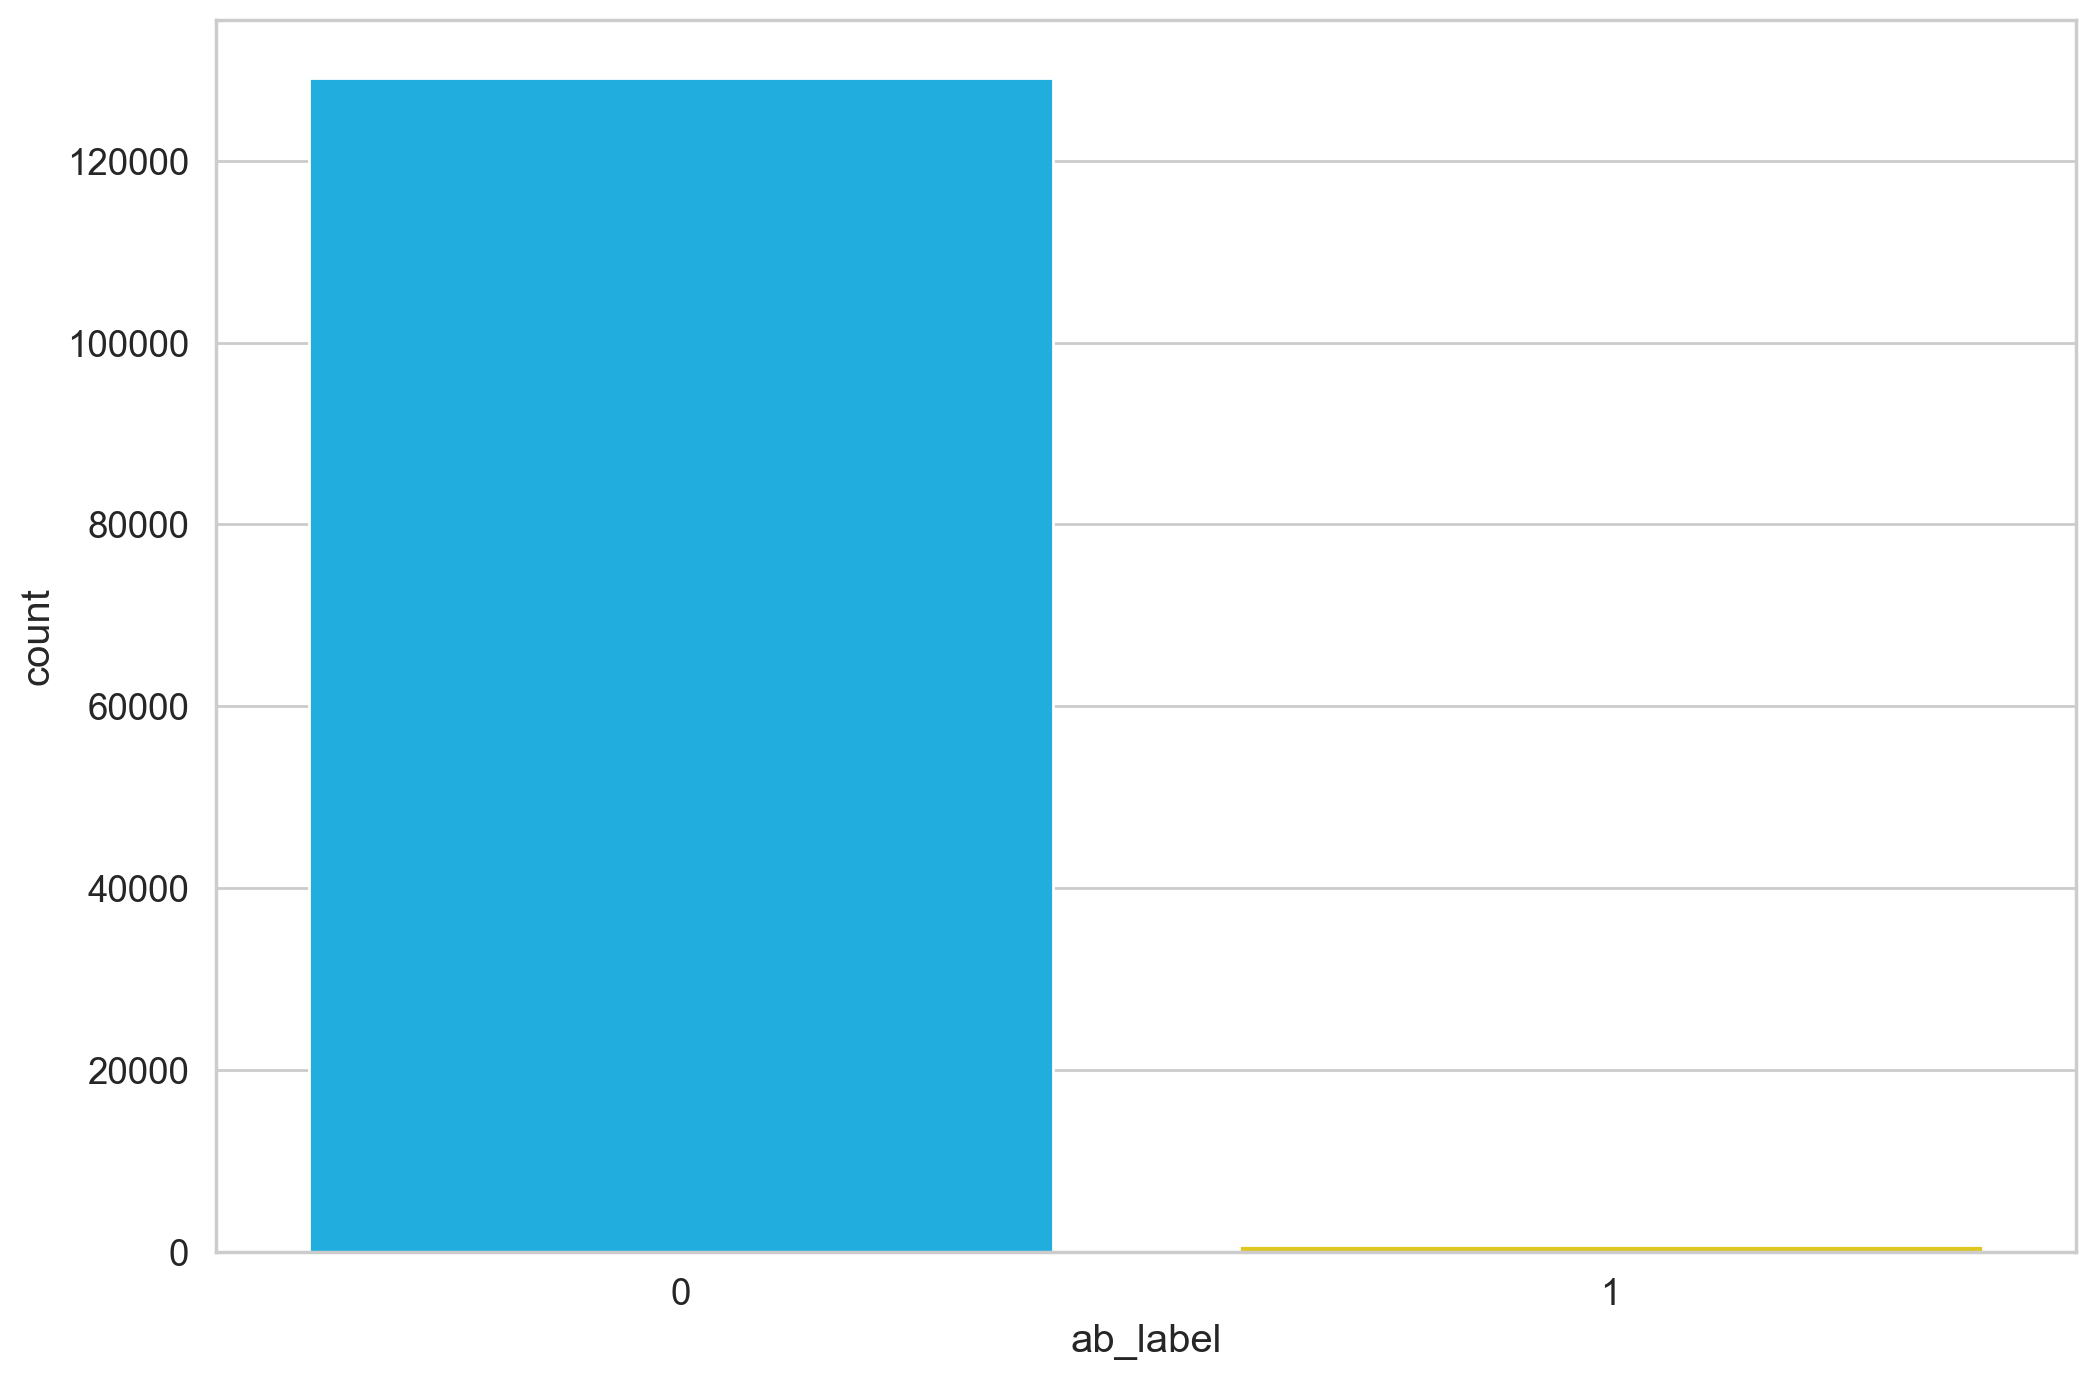

In [8]:
ax = sns.countplot(x='ab_label', data=df)
ax.set_xticklabels(class_names);

In [9]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)

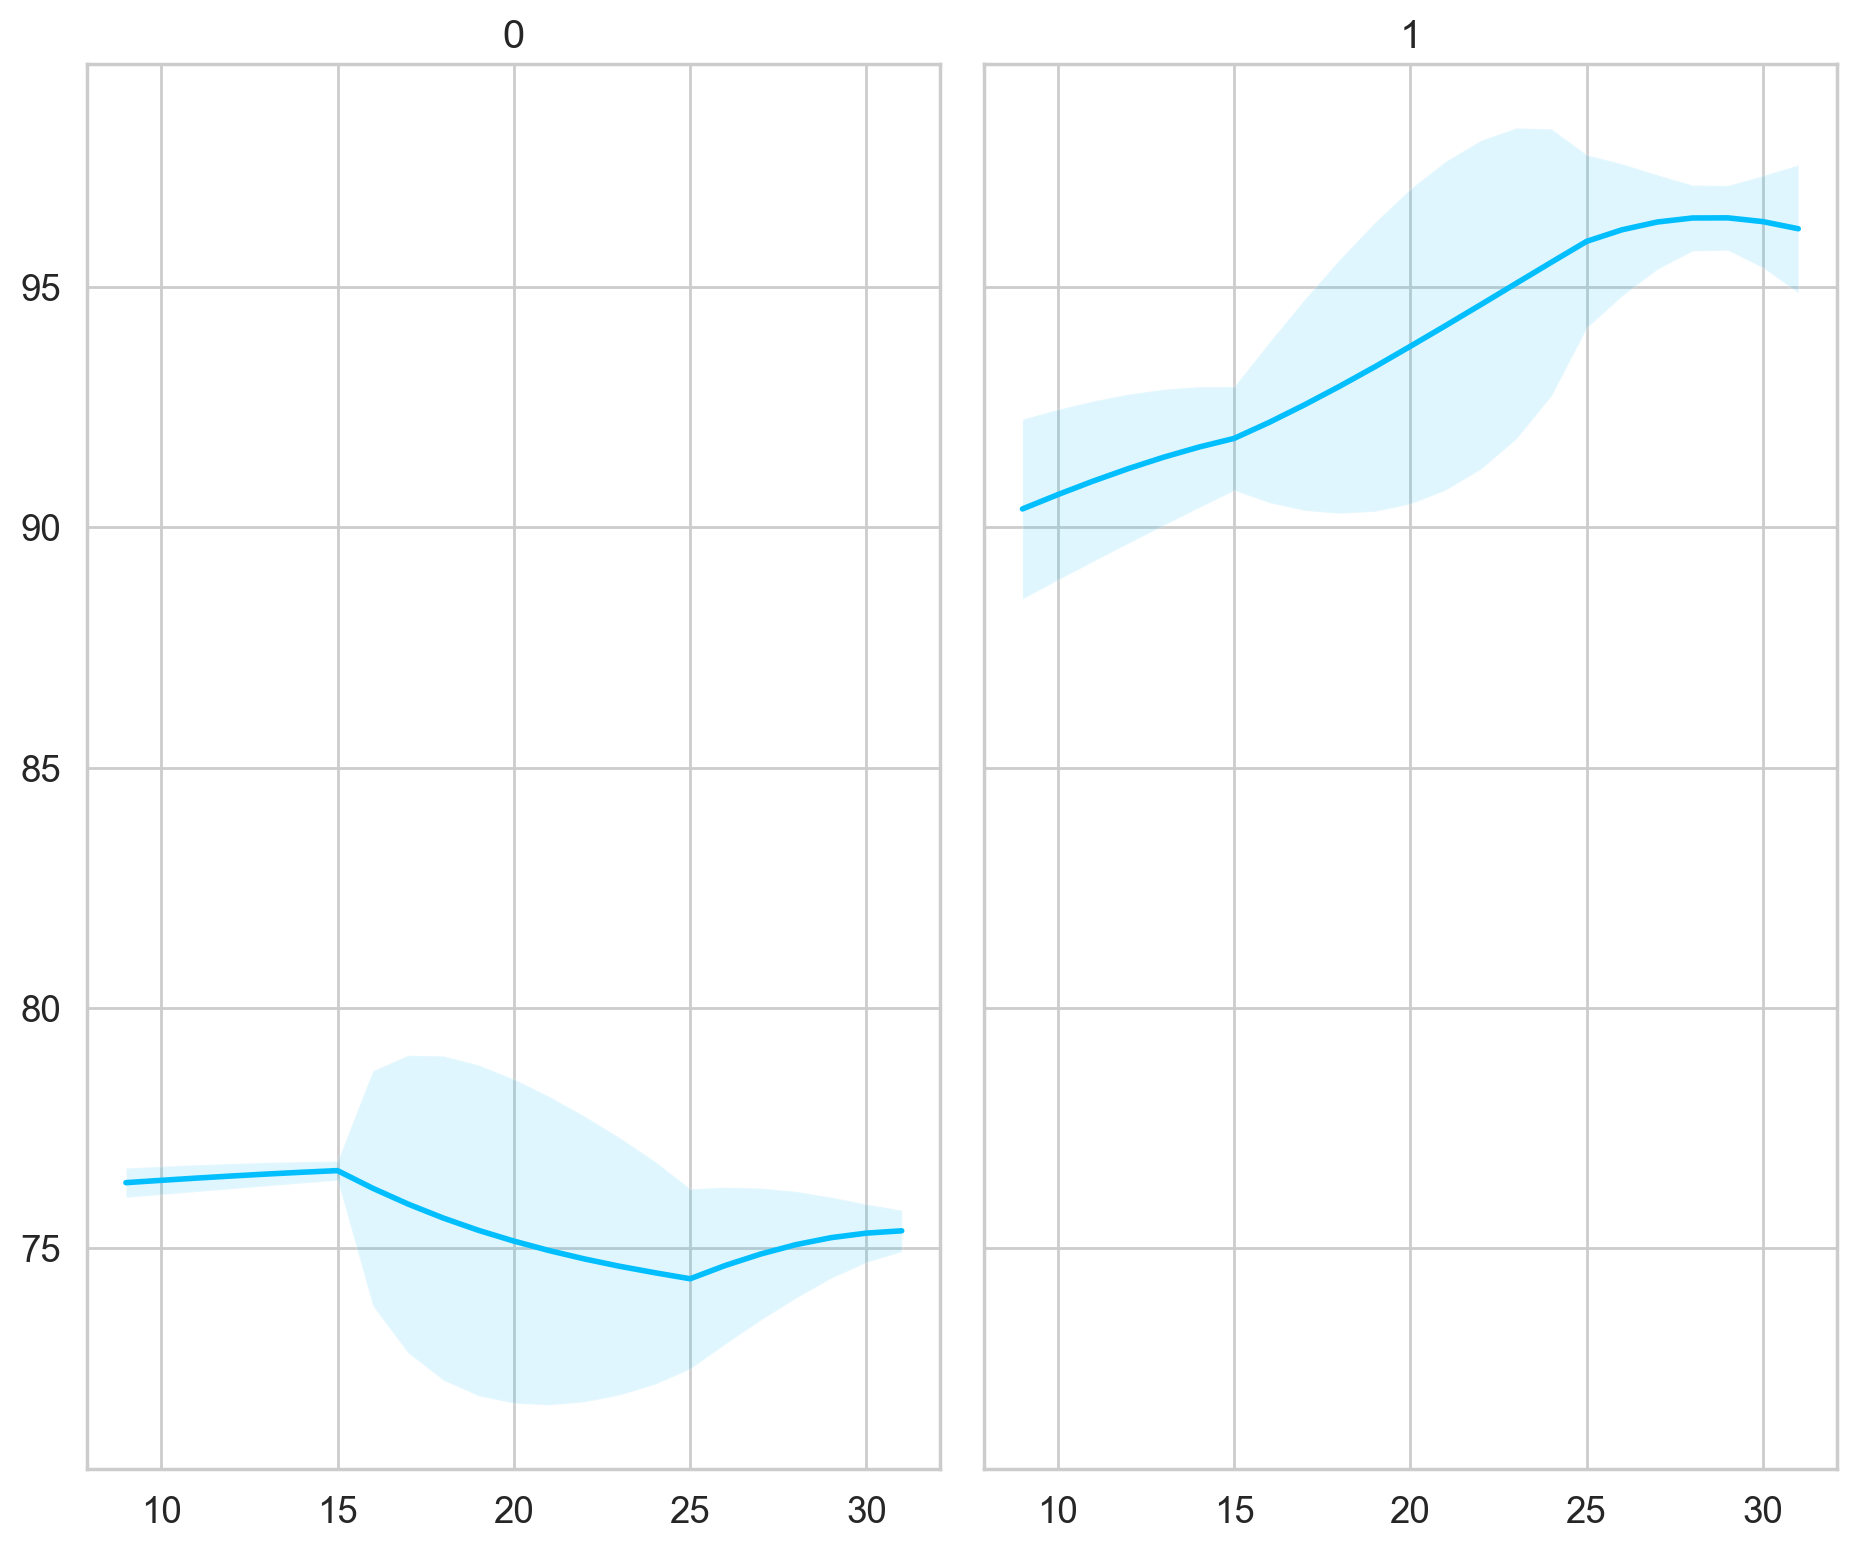

In [10]:
classes = df['ab_label'].unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df['ab_label'] == cls] \
    .drop(labels='ab_label', axis=1) \
    .mean(axis=0) \
    .to_numpy()
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

The above charts show the distribution of the shapes of the time series for the normal and abnormal time series.
The shapes are different for the abnormal and normal time series.
We hope that we can train the autoencoder to memorize the shape of the abnormal time series,
and thus differentiate between the normal and abnormal time series.
The extent of the autoencoder to memorize the shapes is measured by the difference between the input pattern and the
corrosponding output pattern. The measurement is called "loss".
The smaller the loss, the better memory.


## Anomaly Detection

### Data Preprocessing

Remove the unwanted columns, otempi, i = 0, 1, ..., 15, and 'loc', 'start', 'end'
otempi might be the temperature readings before the alignment to the regular sample intervals, of 15 minutes.
I, Yu, am not sure about this. (Need to confirm with Stevev Yuan)

In [11]:
df_lab = df.drop(columns=['otemp' + str(i) for i in range(16)] + ['loc', 'start', 'end'])
df_lab

,temp0,temp1,temp2,temp3,temp4,temp5,temp6,temp7,temp8,temp9,temp10,temp11,temp12,temp13,temp14,temp15,ab_label
0,71.3,73.5,73.8,70.6,72.2,74.6,72.0,70.7,73.3,73.4,70.7,71.7,74.5,71.9,70.5,73.0,0
1,76.3,77.8,77.4,76.5,76.6,77.6,77.1,76.2,73.5,74.9,76.7,77.5,77.8,77.4,77.6,76.1,0
2,73.4,73.7,73.6,73.5,73.4,73.5,73.7,73.8,73.7,73.5,73.5,73.6,73.9,73.4,73.4,73.8,0
3,77.9,78.0,78.2,78.1,78.0,77.9,78.1,78.2,78.1,78.2,78.2,78.3,78.2,78.3,78.2,78.3,0
4,72.4,73.0,73.2,73.0,72.1,71.8,72.2,71.8,72.3,72.5,73.4,73.2,72.6,72.3,71.8,72.1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129787,71.6,70.9,71.0,70.0,70.7,70.0,69.2,70.1,70.0,70.5,71.1,71.5,72.3,73.0,73.3,73.8,0
129788,81.8,81.9,82.0,82.0,82.2,82.3,82.5,82.6,82.7,82.8,82.9,83.1,83.2,83.4,83.5,83.7,0
129789,75.5,75.7,76.0,76.1,76.3,76.3,76.4,76.3,76.5,76.4,76.4,76.4,76.1,75.7,75.5,74.9,0
129790,75.2,75.6,75.7,76.1,76.5,76.7,76.9,77.4,77.8,77.8,77.5,77.7,77.5,77.5,77.4,77.3,0


Extract only the time series with label 1, abnormal, for training the autoencoder.

In [14]:
df_abnormal = df_lab[df_lab['ab_label'] == 1].drop(columns='ab_label')
# df_abnormal = df_lab[lambda df: df['ab_label'] == 1].drop(labels='ab_label', axis=1) # same as above, but more complicated
df_abnormal

# save for later use
df_abnormal.to_csv("../../data/labeled/abnormal_test.zip")

Extract the time series with label 0, normal, for testing the autoencoder.

In [13]:
df_normal = df_lab[df_lab['ab_label'] == 0].drop(columns='ab_label')

# random shuffle the normal time series
df_normal = df_normal.sample(frac=1).reset_index(drop=True)

# save df_normal for later use
df_normal.to_csv("../../data/labeled/normal_test.zip")

In [14]:
# df_normal = df_lab[lambda df: df['ab_label'] == 0].drop(labels='ab_label', axis=1)
df_normal

,temp0,temp1,temp2,temp3,temp4,temp5,temp6,temp7,temp8,temp9,temp10,temp11,temp12,temp13,temp14,temp15
0,77.4,77.7,77.7,77.4,77.8,77.6,77.4,77.3,77.6,77.4,77.3,77.1,77.4,77.3,77.2,76.9
1,73.6,73.1,72.9,73.2,73.2,73.0,73.1,73.0,73.0,73.3,73.2,73.1,73.2,73.4,73.1,73.2
2,74.7,75.0,74.8,74.8,74.9,74.9,75.0,75.1,75.2,75.4,75.6,75.7,75.8,75.8,76.0,76.1
3,79.4,79.5,79.4,79.3,79.5,79.6,79.6,79.6,79.6,79.5,79.7,79.7,79.6,79.6,79.8,79.7
4,77.2,75.2,74.3,77.3,76.2,74.4,74.8,77.9,75.7,74.1,75.7,77.9,75.2,73.8,76.5,76.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129086,76.5,77.2,75.7,77.5,76.2,77.6,76.7,76.4,77.4,76.0,77.4,76.6,76.2,77.4,76.1,76.9
129087,72.3,72.6,72.6,72.6,72.6,72.5,72.3,72.4,72.1,72.0,72.0,71.8,71.7,71.8,71.6,71.3
129088,81.1,81.2,81.2,81.2,81.2,81.3,81.3,81.2,81.3,81.3,81.3,81.3,81.3,81.4,81.4,81.3
129089,74.8,75.2,75.5,73.8,75.0,75.3,75.5,73.7,74.8,75.2,75.4,73.9,74.5,75.0,75.1,75.2


Split the abnormal time series into training, validation and test sets.

In [15]:
train_df, val_test_df = train_test_split(
  df_abnormal,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_test_df,
  test_size=0.33, 
  random_state=RANDOM_SEED
)

Prepare the data for training the autoencoder per PyTorch's requirement.

In [16]:
def create_dataset(df):
  sequences = df.astype(np.float32).to_numpy().tolist()
  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
  n_seq, seq_len, n_features = torch.stack(dataset).shape
  return dataset, seq_len, n_features

Note, we only use the abnormal time series for training the autoencoder, and split the abnormal time series into training, validation and test sets
for abnomal time series.

Thus we have all the data for normal time series for testing the autoencoder.

In [17]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)

test_abnormal, _, _ = create_dataset(test_df)
test_normal, _, _ = create_dataset(df_normal.iloc[:len(test_df)]) # just use equal number of normal time series for testing

In [18]:
train_dataset[0].size(), seq_len, n_features

(torch.Size([16, 1]), 16, 1)

### Autoencorder Model Definitions
This is the same model from that for ECG data, with the only the dimension of the bottleneck changed.

In [19]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

In [20]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [21]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim, device):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

### Use GPU if available
It will makes the training much faster.

In [22]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [23]:
model = RecurrentAutoencoder(seq_len, n_features, 64, device) # embedding_dim from 64 to 16
model = model.to(device)

### Training

Use a rather small n_epochs, 10, for demonstration purpose. For real application, use a larger number, e.g., 100.

In [24]:
def train_model(model, train_dataset, val_dataset, n_epochs=10):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

Training with embedding_dim=16 changed from 64

In [25]:
model, history = train_model(
  model, 
  train_dataset, 
  val_dataset, 
  n_epochs= 10 # 100
)

Epoch 1: train loss 737.6760976070116 val loss 112.73867486228406
Epoch 2: train loss 58.27659044025325 val loss 60.95506168419207
Epoch 3: train loss 56.68690207345145 val loss 60.95353268905425
Epoch 4: train loss 56.66980874197824 val loss 60.950363803917256
Epoch 5: train loss 56.67398409803374 val loss 60.94394737566021
Epoch 6: train loss 56.66429180497883 val loss 60.93635967415823
Epoch 7: train loss 56.66320260953503 val loss 60.95429133025693
Epoch 8: train loss 56.6630946183405 val loss 60.94467249050946
Epoch 9: train loss 56.65819018708557 val loss 60.935398370447295
Epoch 10: train loss 56.65311286990382 val loss 60.925862272020794


NameError: name 'history' is not defined

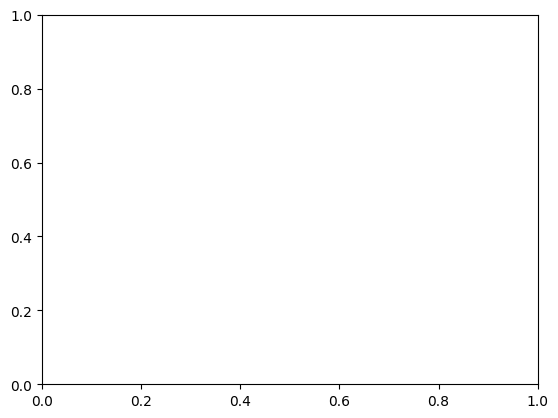

In [3]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

Training epochs have been tried:
- 10
- 100
- 1000

It seems that the lost curve and evaluation performance are almost the same for the number of epochs with embedding_dim=64.

With embedding_dim=16, for epochs=100, the lost curve looks the same of "hocky stick".

### Saving the model parameters

In [27]:
# Get the date and time as string of timestamp:
import datetime
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
MODEL_PATH = '../../model/ac_anomaly_autoencoder_model_state_dict_'+timestamp+'.pth'
torch.save(model.state_dict(), MODEL_PATH)

The savede model name is timestamped. For those of interest, they are renamed off-line afterwards.

### Choosing a threshold of losses
The loss is a metric of how similiar between the input and the output of the autoencoder.
The smaller the loss, the better the autoencoder is able to reconstruct the input.
As the autoencoder is trained on abnormal data, the loss of normal data should be higher than the loss of abnormal data.
We hope to find a threshold of loss such that the loss of abnormal data is lower than the threshold,
while the loss of normal data is higher than the threshold.
If we can find such a threshold of loss, we can use it to discriminate between normal and abnormal temperature patterns

In [37]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

/tmp/ipykernel_21516/1153265548.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(losses, bins=50, kde=True);


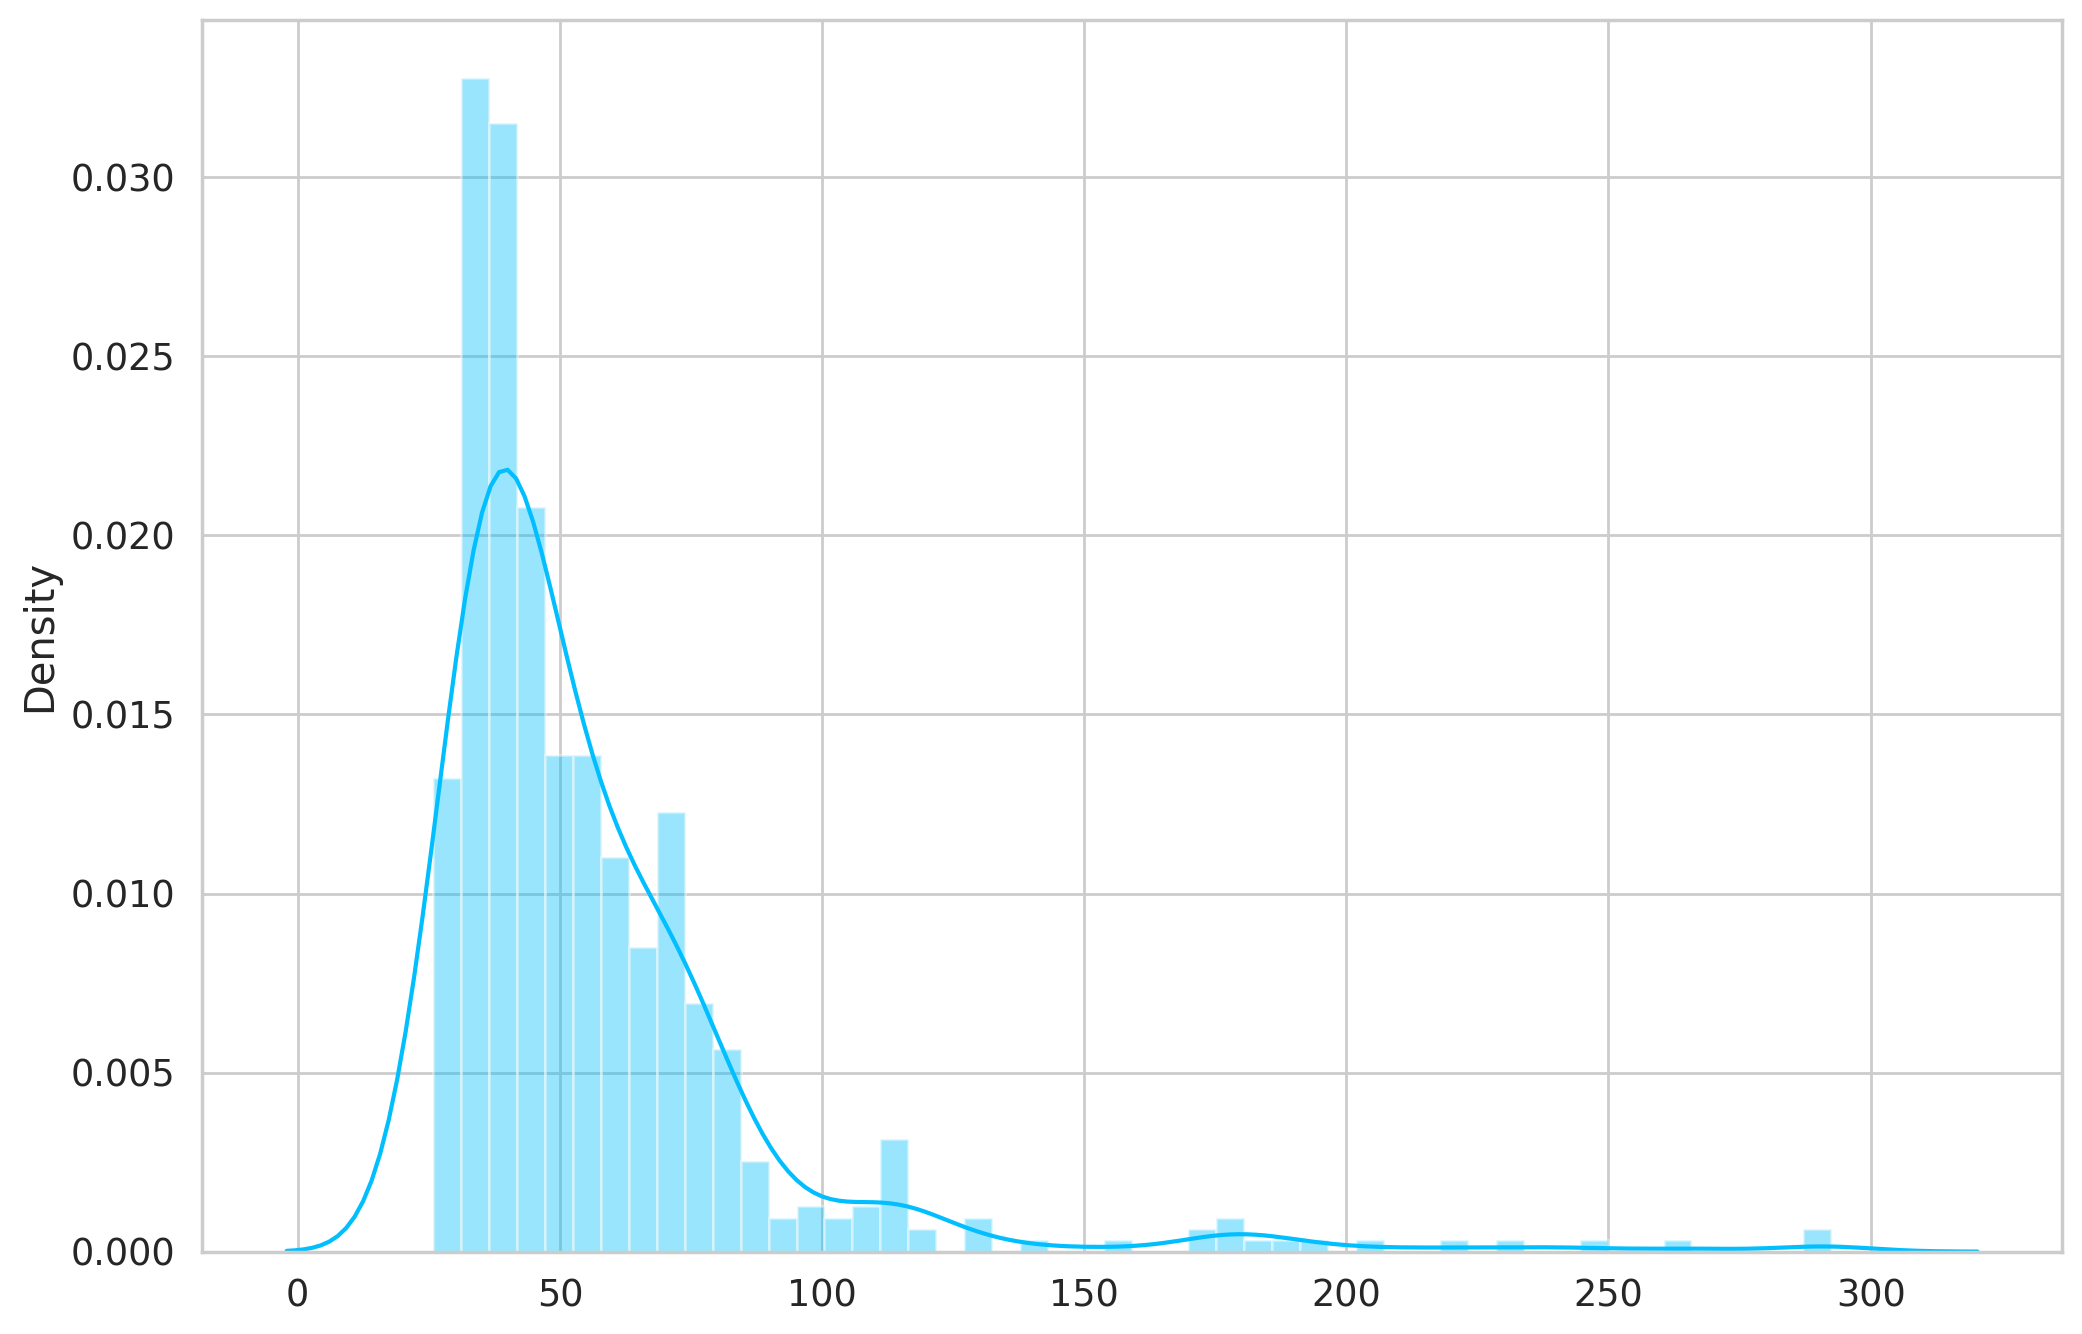

In [38]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True);

Based on the above plot, we choose a threshold of 150, larger than that will be considered as not anomaly, i.e. normal.

In [39]:
THRESHOLD = 150 # 26

### Evaluation

#### Test of Abnormal Temperature Patterns

/tmp/ipykernel_21516/1000911118.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses, bins=50, kde=True);


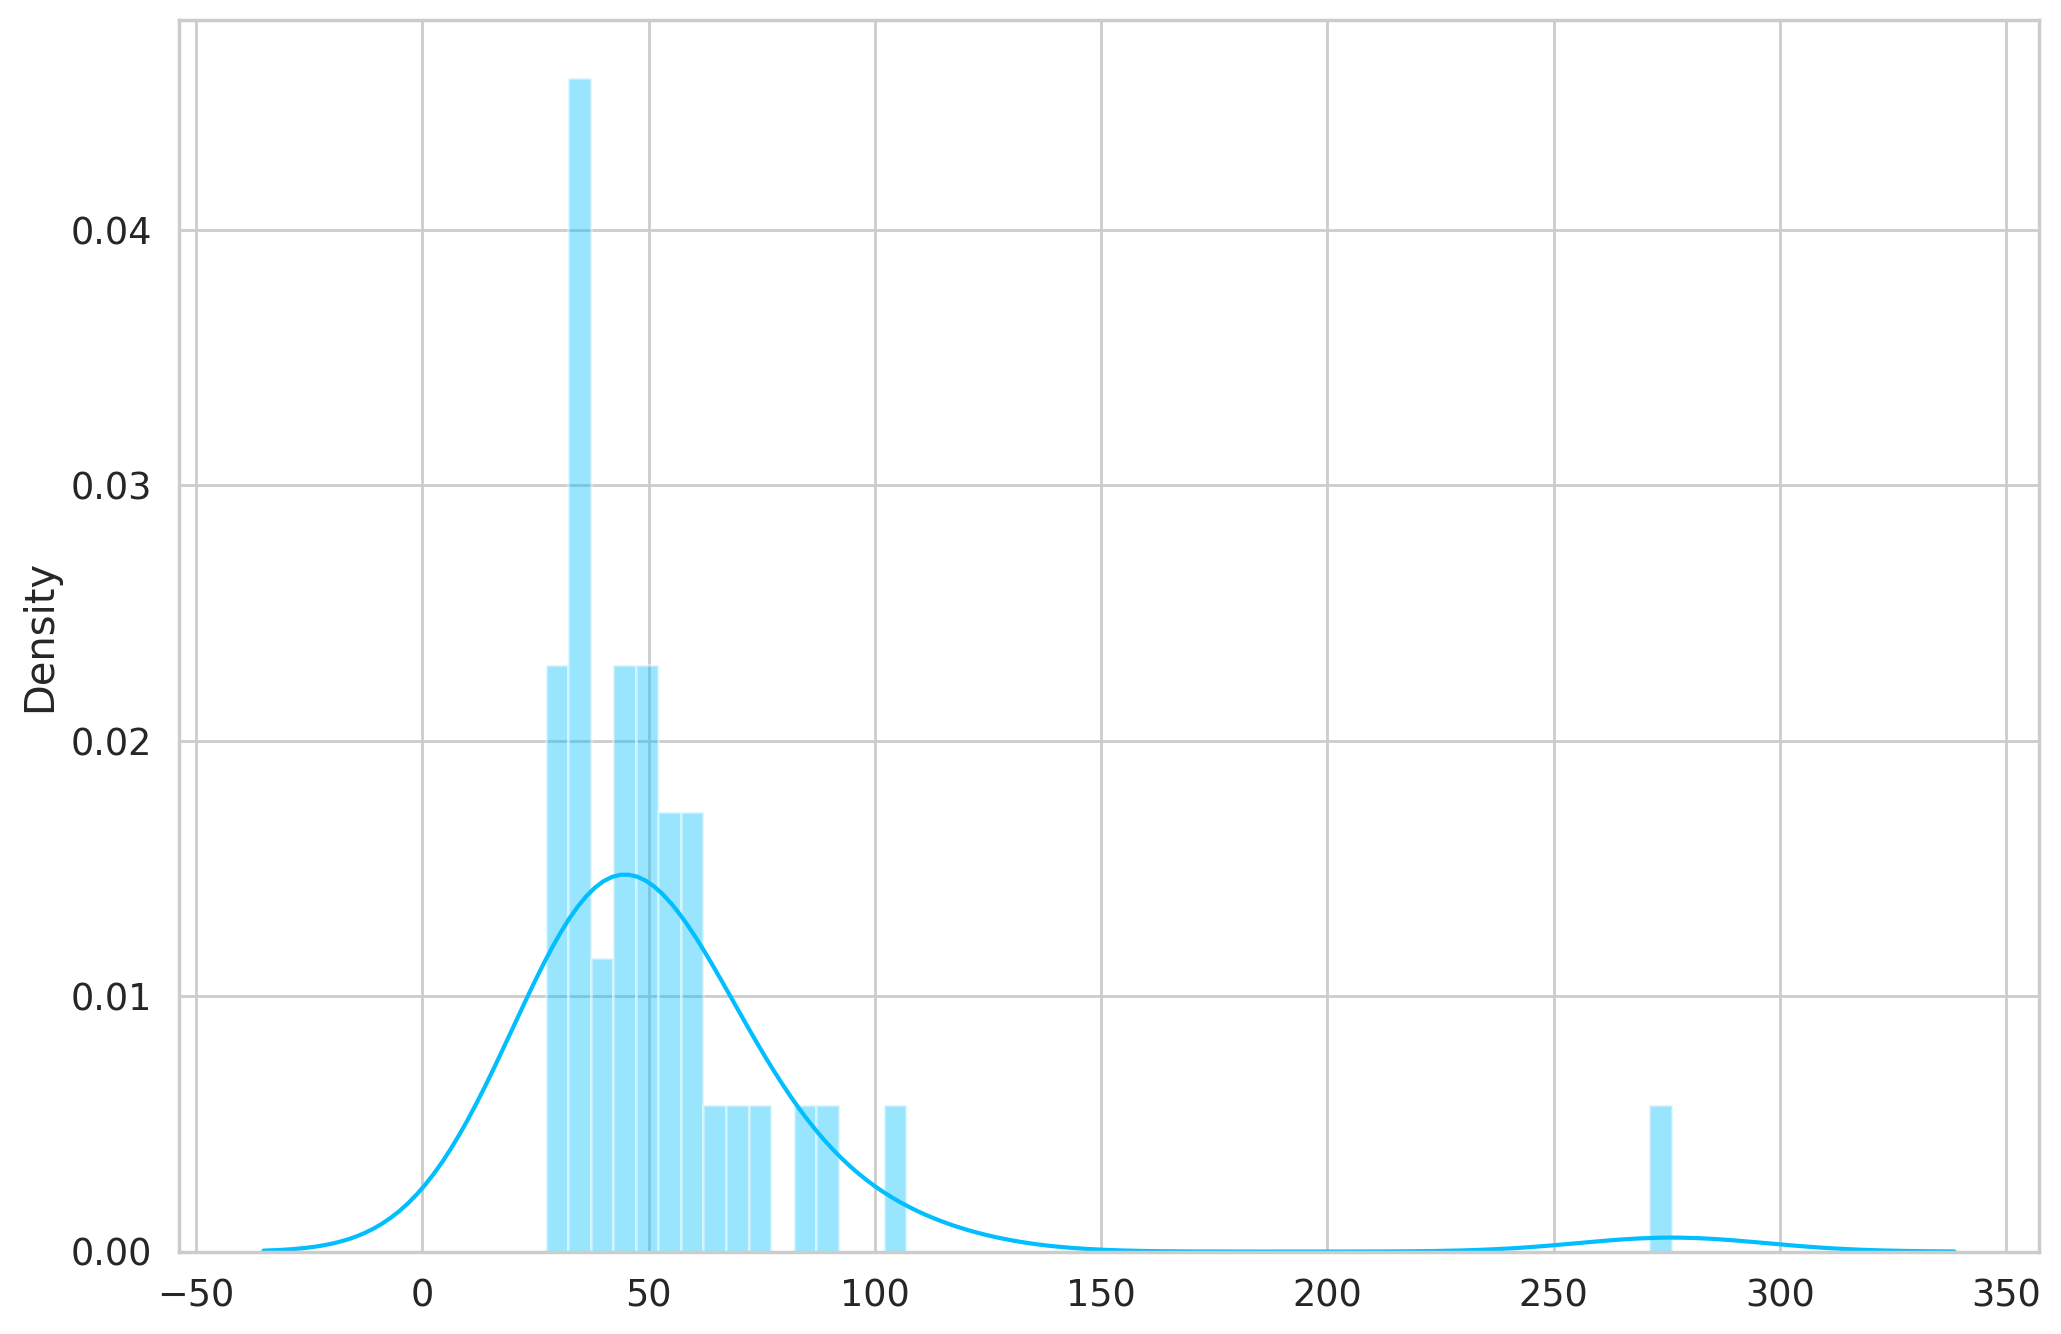

In [40]:
predictions, pred_losses = predict(model, test_abnormal)
sns.distplot(pred_losses, bins=50, kde=True);

In [41]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Accuracy of abnormal predictions: {correct/len(test_abnormal)}')

Accuracy of abnormal predictions: 0.9714285714285714


#### Test of Normal Temperature Patterns

In [43]:
# anomaly_dataset = test_normal

/tmp/ipykernel_21516/3788748725.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses, bins=50, kde=True);


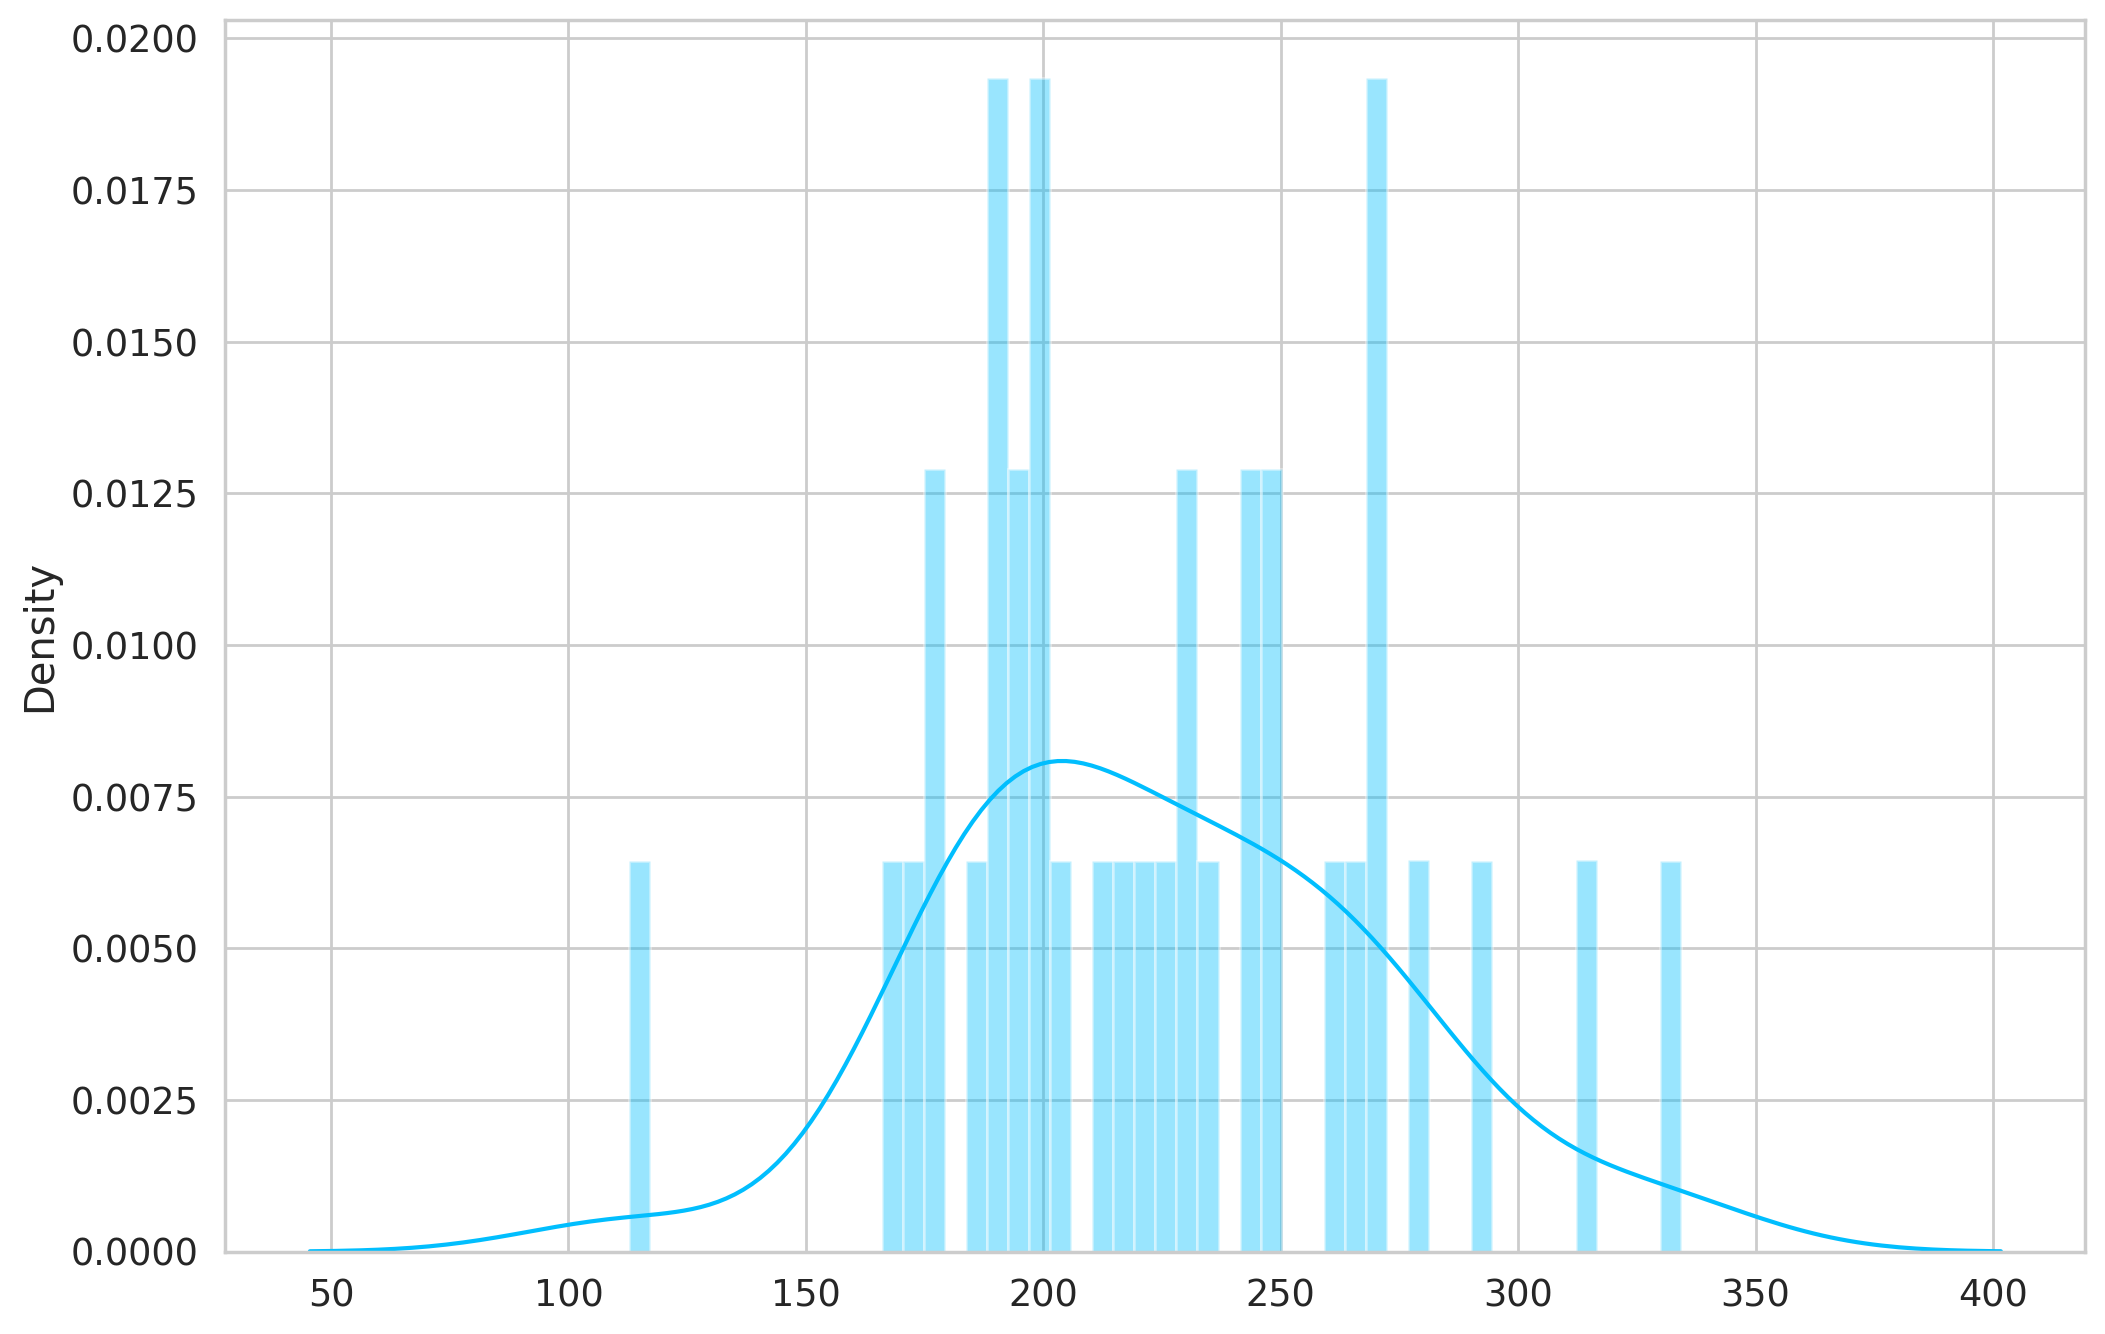

In [42]:
predictions, pred_losses = predict(model, test_normal)
sns.distplot(pred_losses, bins=50, kde=True);

In [43]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Accuracy of normal predictions: {correct/len(test_normal)}')

Accuracy of normal predictions: 0.9714285714285714


#### Looking at Examples

In [44]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])

  ax.plot(data, label='true')
  ax.plot(predictions[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

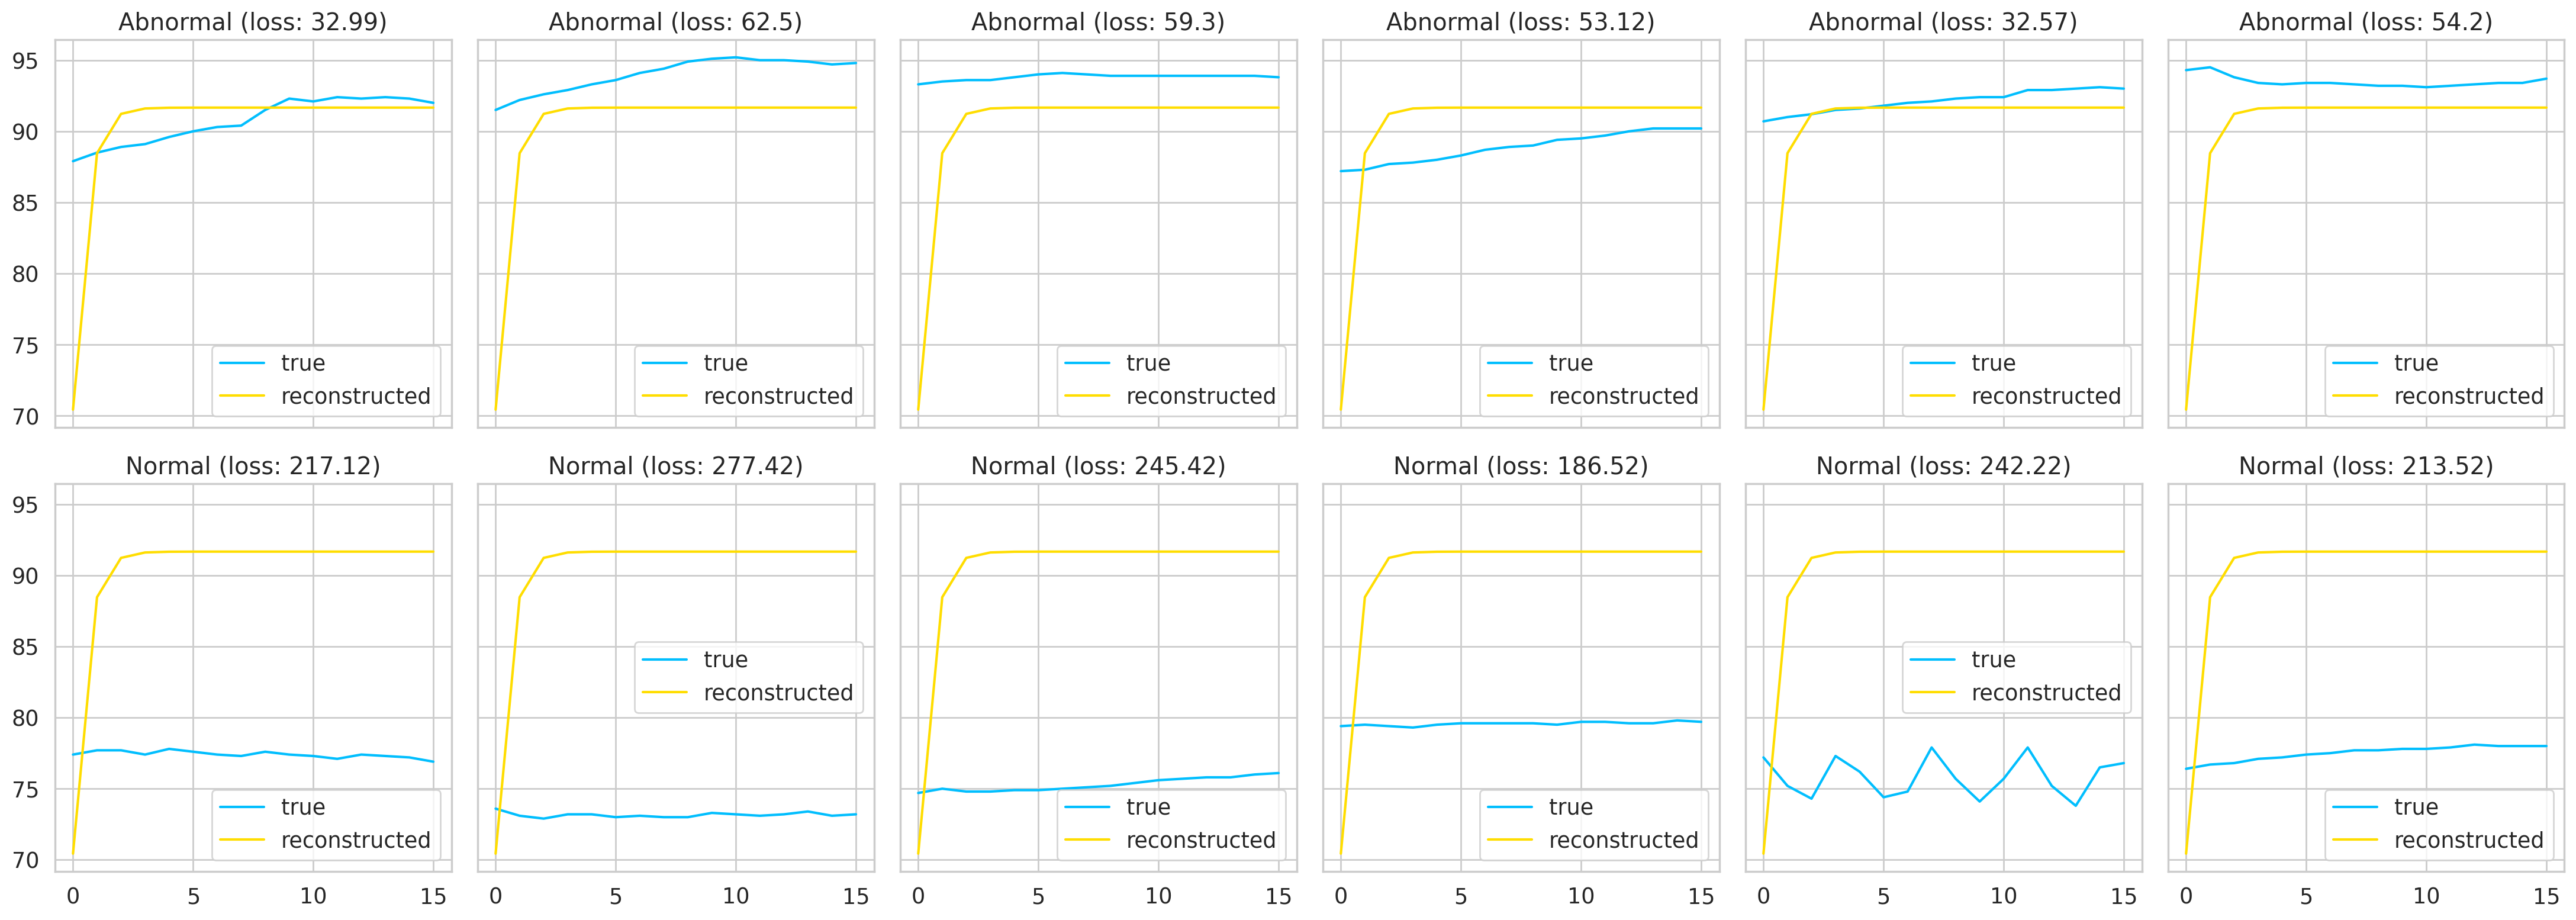

In [45]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_abnormal[:6]):
  plot_prediction(data, model, title='Abnormal', ax=axs[0, i])

for i, data in enumerate(test_normal[:6]):
  plot_prediction(data, model, title='Normal', ax=axs[1, i])

fig.tight_layout();

## Conclusion
The above samples of both normal and abnormal temperature patterns show that
the autoencoder is able to reconstruct the abnormal temperature patterns much better than
the normal temperature patterns.
There is indeed a discrinimination between normal and abnormal temperature patterns, by the value of loss.
The accuracy of the autoencoder is above 97% for both normal and abnormal temperature patterns.

This is just a rather naive experiment. It looks promising of the paradigm of using supervised learning to detect anomalies of air conditioner temperature patterns.

However, more rigorous experiments are needed to further validate the paradigm.

The current labelling of temperature patterns might be too simplistic. It mainly is based on the range of the temperatures.
More considerations of the acceleration of the temperature changes might be needed.

Currently, the interval of the temperature readings is 15 minutes. To have sufficient length of the time series (16), the time window of the temperature readings is 4 hours.
It might be too much delay for detecting abnormality. We might try to have much shorter interval, to have more temperature readings in shorter interval.
We may try to have the interval to be 2 or 3 minutes, then we can have 30 to 20 readings in an hour.
We can experiment to see if the paradigm can be still effective for the shorter sampling interval.

The supervised learning paradim while looking promising, it takes substantial amount of effort to label the tarining data.
A better mechanism is needed to make the labelling more productive.
It would be even better to be able to have a convconvenient labeling tool to enable non-programmer to perform the labeling, and
to have a streamlined work-flow to accumulate the labeled samples.

It would be even better to combine supervised learning with reinforcement training to further improve the detection capabilities.

Another research direction is to explore the neural network architecture. The default embedding_dim is 64. Given the training and validation are rather trivially successful, maybe, we can reduce embedding_dim to 16, or even smaller?
With embedding_dim=16, the performance of both training and validation are almost identical to those with embedding_dim=64.